In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# config
import yaml
config_dir = "./dic_for_10_steps/config.yaml"
def read_config_file(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config
config = read_config_file(config_dir)

In [36]:
import torch
import os
model_dict = torch.load(os.path.join(config['save_dir'], 'best_model.pth'))
print(model_dict.keys())

odict_keys(['std_layer_1.mean', 'std_layer_1.std', 'std_layer_u.mean', 'std_layer_u.std', 'pca_transformer.transform.weight', 'pca_transformer.inverse_transform.weight', 'std_layer_2.mean', 'std_layer_2.std', 'state_dic.input_layer.weight', 'state_dic.input_layer.bias', 'state_dic.layers.0.layer1.weight', 'state_dic.layers.0.layer1.bias', 'state_dic.layers.0.layer2.weight', 'state_dic.layers.0.layer2.bias', 'state_dic.layers.1.layer1.weight', 'state_dic.layers.1.layer1.bias', 'state_dic.layers.1.layer2.weight', 'state_dic.layers.1.layer2.bias', 'state_dic.layers.2.layer1.weight', 'state_dic.layers.2.layer1.bias', 'state_dic.layers.2.layer2.weight', 'state_dic.layers.2.layer2.bias', 'state_dic.layers.3.layer1.weight', 'state_dic.layers.3.layer1.bias', 'state_dic.layers.3.layer2.weight', 'state_dic.layers.3.layer2.bias', 'state_dic.layers.4.layer1.weight', 'state_dic.layers.4.layer1.bias', 'state_dic.layers.4.layer2.weight', 'state_dic.layers.4.layer2.bias', 'state_dic.layers.5.layer1.we

In [37]:
model_dict['std_layer_1.mean']

tensor([-0.0016,  0.0003, -0.0100,  ..., -0.0001, -0.0002,  0.0023],
       device='cuda:0')

In [38]:
import os
from model_dir import *
x_dim = 6957
u_dim = 20
params = Params(x_dim, u_dim, config)
model= build_model(params)
model.load_state_dict(torch.load(os.path.join(config['save_dir'], 'best_model.pth')))

<All keys matched successfully>

In [39]:
model.std_layer_1.mean

Parameter containing:
tensor([-0.0016,  0.0003, -0.0100,  ..., -0.0001, -0.0002,  0.0023])

In [55]:
def load_val_dataset(data_dict, predict_num, begin = 0, end = 151):
    time = []
    data = []
    I_p = []
    for _, contents in data_dict.items():
        time.append(contents['time'])
        data.append(contents['data'])
        I_p.append(contents['I_p'])
    
    data = np.array(data)
    x_data = data[begin:end,:]
    u_data = np.concatenate((np.reshape(np.array(I_p)[begin:end-1], (-1,1)), np.reshape(np.array(I_p)[begin+1:end], (-1,1))), axis = 1)

    u_data_slices = []
    for k in range(len(x_data) - predict_num):
        if k + predict_num > len(u_data):
            raise ValueError("The requested prediction number exceeds the bounds of u_data.")
        u_data_slice = u_data[k:k+predict_num, :].reshape(1, -1)
        u_data_slices.append(u_data_slice)
    u_data = np.concatenate(u_data_slices, axis= 0)
    return x_data, u_data

In [57]:
# load data
begin, end = 50, 150
x_dataset, u_dataset = [], []
data_dir = config["data_dir"]
for item in os.listdir(data_dir):
    data_file_path = os.path.join(data_dir, item)
    # Check if the file exists before trying to load it
    if data_file_path.endswith('.npy') and os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, u_data = load_val_dataset(data_dict, config['predict_num'], begin = begin, end = end + 1)
    x_dataset.append(x_data)
    u_dataset.append(u_data)

In [58]:
window_size = end - begin
predict_num = config['predict_num']
n_step = window_size//predict_num
device = torch.device('cpu')
print(n_step)

10


In [59]:
x_dataset_pred = []
x_dataset_true = []
x_pca_dataset_pred = []
x_pca_dataset_true = []

for i in range(len(x_dataset)):
    x_data = x_dataset[i]
    u_data = u_dataset[i]
    x0 = x_data[0:predict_num, :]
    psi_x = model.dic(torch.tensor(x0).float().to(device))
    
    x_data_pred = x0  # Start with the initial state
    x_pca_pred = psi_x.detach().cpu().numpy()[:, 1:config['pca_dim'] + 1].copy()  # Make a copy for the initial state
    
    x_dataset_true.append(x_data[:n_step * predict_num, :])
    x_pca_dataset_true.append(model.encode(torch.tensor(x_data[:n_step * predict_num], dtype=torch.float32)).detach().cpu().numpy())

    for j in range(n_step - 1):
        u = u_data[j * predict_num: (j + 1) * predict_num, :]
        psi_y = model.latent_to_latent_forward(psi_x, torch.tensor(u).float().to(device))
        x_pred = model.decode(psi_y).detach().cpu().numpy()
        psi_x = psi_y  # Update psi_x for the next iteration
        x_data_pred = np.concatenate((x_data_pred, x_pred), axis=0)
        psi_x_copy = psi_x.detach().cpu().numpy()[:, 1:config['pca_dim'] + 1].copy()  # Make a copy of the current state
        x_pca_pred = np.concatenate((x_pca_pred, psi_x_copy), axis=0)  # Use the copy
    x_pca_dataset_pred.append(np.array(x_pca_pred))
    x_dataset_pred.append(x_data_pred)

In [60]:
errors = [x_dataset_true[i] - x_dataset_pred[i] for i in range(len(x_dataset_true))]
errors_pca = [x_pca_dataset_true[i] - x_pca_dataset_pred[i] for i in range(len(x_pca_dataset_true))]

cumulative_error_norms = [np.array([np.linalg.norm(errors[i][:j+1,:]) for j in range(errors[i].shape[0])]) for i in range(len(errors))]
cumulative_error_norms_pca = [np.array([np.linalg.norm(errors_pca[i][:j+1,:]) for j in range(errors_pca[i].shape[0])]) for i in range(len(errors_pca))]

data_norms = [np.linalg.norm(x_dataset_true[i]) for i in range(len(x_dataset_true))]

data_norms_pca = [np.linalg.norm(x_pca_dataset_true[i]) for i in range(len(x_pca_dataset_true))]

relative_errors = [cumulative_error_norms[i] / data_norms[i] for i in range(len(cumulative_error_norms))] 


In [61]:
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

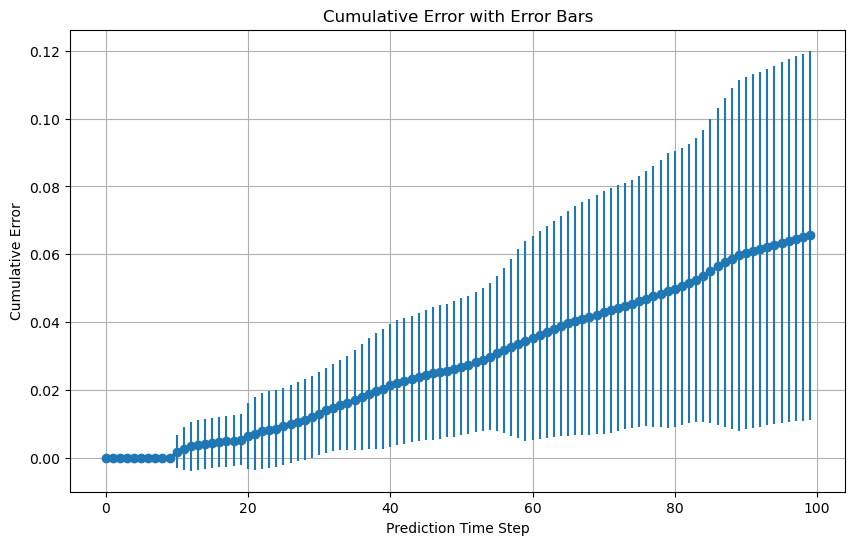

In [62]:

# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(n_step * predict_num), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Prediction Time Step')
plt.ylabel('Cumulative Error')
plt.title('Cumulative Error with Error Bars')
plt.grid(True)
plt.show()

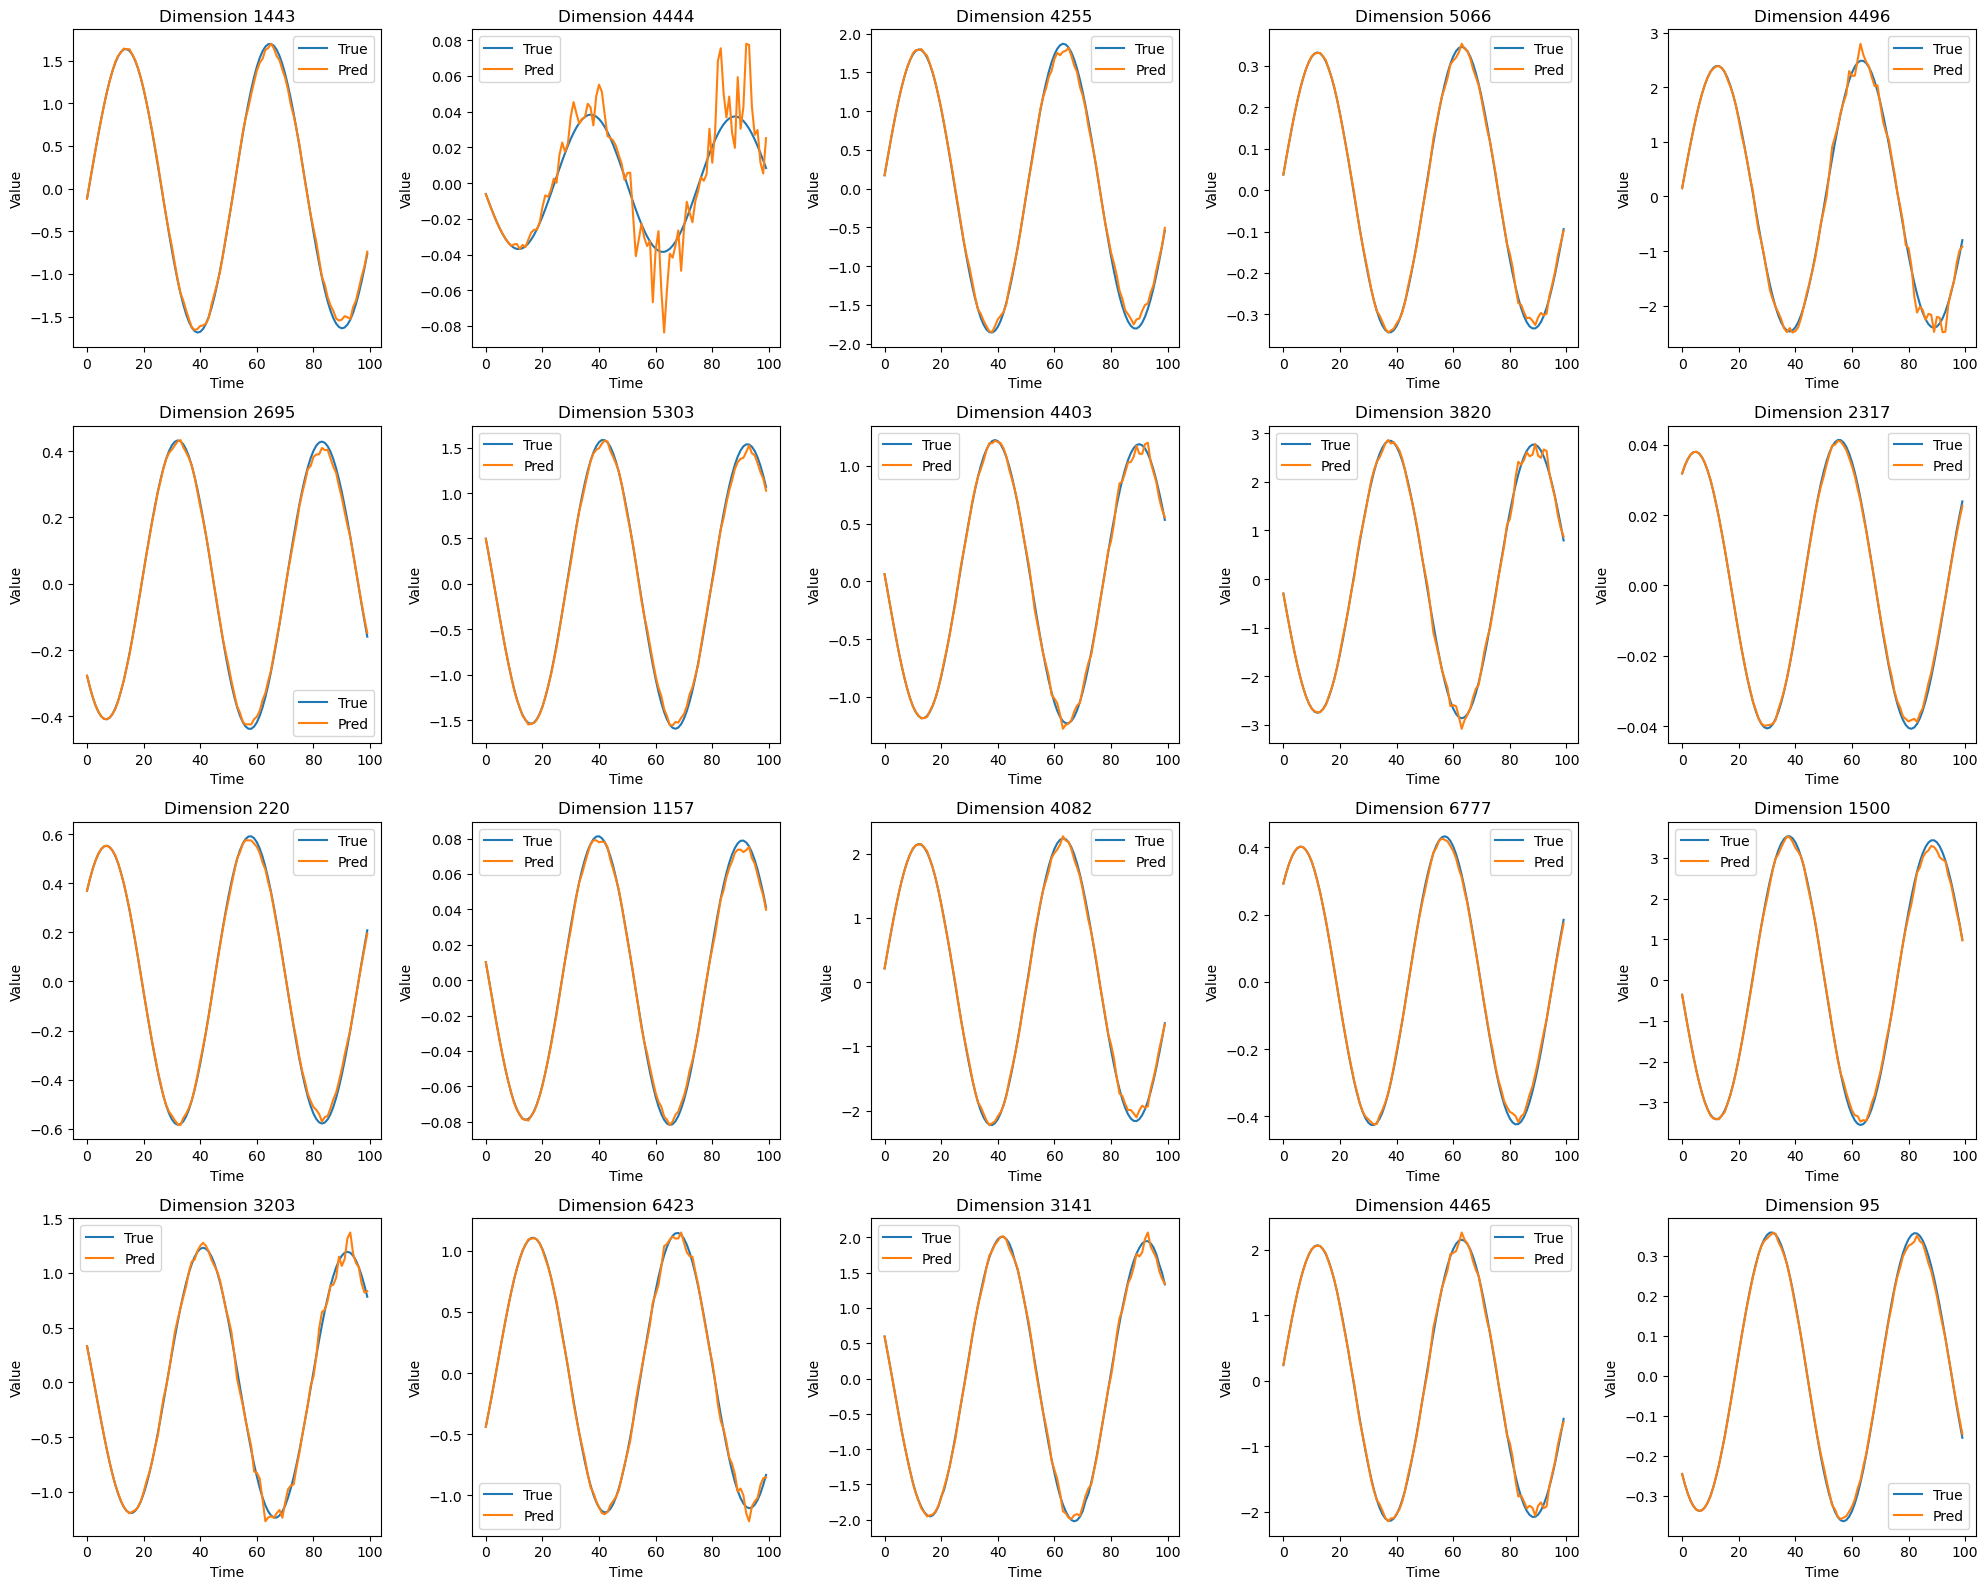

In [65]:
import numpy as np
import matplotlib.pyplot as plt

k = 1
n_dimensions = x_dataset_true[k].shape[1]
selected_dimensions = np.random.choice(n_dimensions, 20, replace=False)

fig, axs = plt.subplots(4, 5, figsize=(20, 16))

x_true = x_dataset_true[k]
x_pred = x_dataset_pred[k]

for idx, dim in enumerate(selected_dimensions):
    row = idx // 5
    col = idx % 5
    
    axs[row, col].plot(x_true[:, dim], label='True')
    axs[row, col].plot(x_pred[:, dim], label='Pred')
    axs[row, col].set_title(f'Dimension {dim}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.tight_layout()
plt.show()


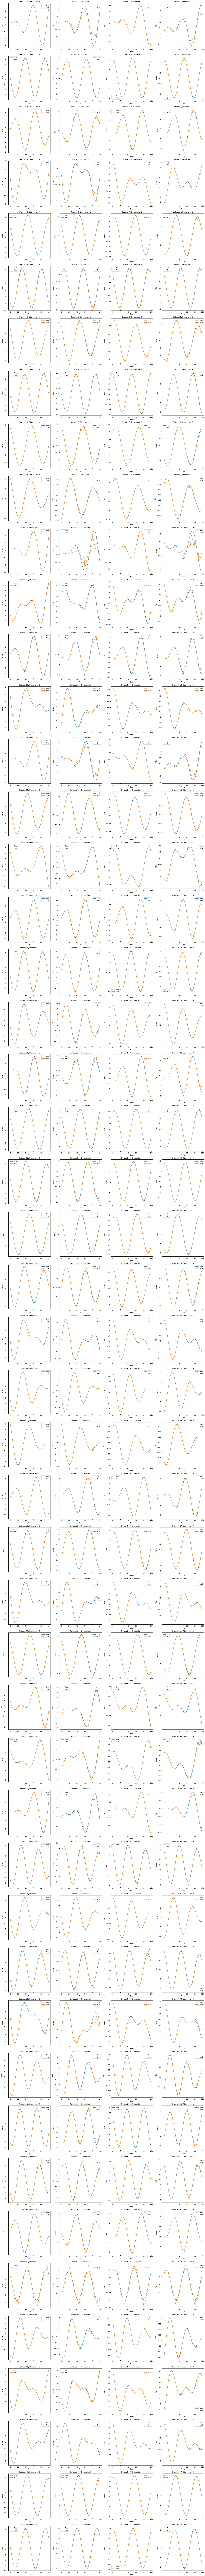

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_data_pca_dataset and x_data_pca_pred_dataset are your loaded datasets

# Create a large figure
fig, axs = plt.subplots(len(x_pca_dataset_true), 4, figsize=(20, 250))  # Note: This will create 200 plots!

for k in range(len(x_pca_dataset_true)):  # Iterate through the first 50 datasets
    x_true = x_pca_dataset_true[k]
    x_pred = x_pca_dataset_pred[k]

    for dim in range(4):
        # Plot for the first 4 dimensions of each dataset
        ax = axs[k, dim]
        ax.plot(x_true[:, dim], label='True')  # Plot true values
        ax.plot(x_pred[:, dim], label='Pred')  # Plot predicted values
        ax.set_title(f'Dataset {k}, Dimension {dim}')  # Set title
        ax.set_xlabel('Time')  # Set x-axis label
        ax.set_ylabel('Value')  # Set y-axis label
        ax.legend()  # Show legend

plt.tight_layout()  # Adjust layout
plt.show()  # Display the figure
